<a href="https://colab.research.google.com/github/Tejasri1610/MAJORPY/blob/main/MAJOR_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

In [2]:
"""
Supply Chain Demand Forecasting - Part 1: GCN Baseline Model
==============================================================
This notebook implements a Graph Convolutional Network (GCN) baseline
for supply chain reliability prediction and demand forecasting.
"""

# ============================================================================
# 1. INSTALLATION & IMPORTS
# ============================================================================
# !pip install torch torch-geometric pandas scikit-learn matplotlib numpy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# ============================================================================
# 2. DATA LOADING & PREPROCESSING
# ============================================================================
print("="*70)
print("LOADING DATA")
print("="*70)

# Load datasets
nodes_and_target_df = pd.read_csv("Nodes and Edges (Plant & Storage).csv")
features_df = pd.read_csv("dynamic_supply_chain_logistics_dataset_updated.csv")
sales_df = pd.read_csv("Sales_Order_Updated_2024.csv")

# Create edges from supplier-product relationships
edges_df = features_df[['supplier_id', 'product_id']].drop_duplicates()
edges_df = edges_df.rename(columns={'supplier_id': 'src', 'product_id': 'dst'})
features_df = features_df.rename(columns={'supplier_id': 'node_id'})

# Aggregate features by node
agg_functions = {col: 'mean' for col in features_df.select_dtypes(include=np.number).columns}
agg_functions.update({col: 'first' for col in features_df.select_dtypes(include='object').columns if col != 'node_id'})
aggregated_features_df = features_df.groupby('node_id').agg(agg_functions).reset_index()

# Merge node features with target
nodes_df = pd.merge(nodes_and_target_df, aggregated_features_df, on='node_id', how='left').fillna(0)

print(f"Nodes shape: {nodes_df.shape}")
print(f"Edges shape: {edges_df.shape}")
print(f"Sales shape: {sales_df.shape}\n")

# ============================================================================
# 3. FEATURE SELECTION & ENCODING
# ============================================================================
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Select 4 key features for node representation
feature_cols = [
    'lead_time_days',
    'order_fulfillment_status',
    'cargo_condition_status',
    'supplier_country'
]

# Encode categorical features
if nodes_df['supplier_country'].dtype == 'object':
    nodes_df['supplier_country'] = nodes_df['supplier_country'].astype('category').cat.codes

print(f"Selected features: {feature_cols}\n")

# ============================================================================
# 4. GRAPH CONSTRUCTION
# ============================================================================
print("="*70)
print("BUILDING GRAPH STRUCTURE")
print("="*70)

# Create node mapping
all_nodes = set(nodes_df['node_id'].values)
all_nodes.update(edges_df['src'].dropna().values)
all_nodes.update(edges_df['dst'].dropna().values)
node_mapping = {node: i for i, node in enumerate(sorted(all_nodes))}

print(f"Total nodes in graph: {len(all_nodes)}")

# Build edge index
cleaned_edges_df = edges_df.dropna(subset=['src', 'dst'])
edge_index = torch.tensor([
    [node_mapping[src] for src in cleaned_edges_df['src']],
    [node_mapping[dst] for dst in cleaned_edges_df['dst']]
], dtype=torch.long)

print(f"Total edges in graph: {edge_index.shape[1]}\n")

# ============================================================================
# 5. NODE FEATURES & TARGET
# ============================================================================
# Extract node features
node_features = []
for node in node_mapping.keys():
    if node in nodes_df['node_id'].values:
        row = nodes_df.loc[nodes_df['node_id'] == node, feature_cols].values[0]
    else:
        row = np.zeros(len(feature_cols))
    node_features.append(row)

node_features = torch.tensor(node_features, dtype=torch.float)

# Extract target (supplier reliability)
y = nodes_df.set_index('node_id').reindex(sorted(all_nodes))['supplier_feature_reliability'].fillna(0).values
y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(node_features)
y_scaled = scaler_y.fit_transform(y)

# Create PyG Data object
data = Data(
    x=torch.tensor(X_scaled, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y_scaled, dtype=torch.float)
)

# Train/test split
train_ratio = 0.8
num_nodes = data.num_nodes
indices = torch.randperm(num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:int(train_ratio * num_nodes)]] = True
test_mask[indices[int(train_ratio * num_nodes):]] = True
data.train_mask = train_mask
data.test_mask = test_mask

print(f"Node features shape: {data.x.shape}")
print(f"Training nodes: {train_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}\n")

# ============================================================================
# 6. GCN MODEL DEFINITION
# ============================================================================
print("="*70)
print("GCN MODEL ARCHITECTURE")
print("="*70)

class GCNModel(nn.Module):
    """
    Graph Convolutional Network for supply chain reliability prediction.

    Architecture:
    - 2 GCN layers with ReLU activation
    - Fully connected output layer
    """
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer
        x = F.relu(self.conv1(x, edge_index))
        # Second GCN layer
        x = F.relu(self.conv2(x, edge_index))
        # Output layer
        x = self.fc(x)
        return x

# Initialize model
in_dim = data.num_node_features
hidden_dim = 64
out_dim = 1
model = GCNModel(in_dim, hidden_dim, out_dim).to(device)

print(f"Input dimension: {in_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Output dimension: {out_dim}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}\n")

# ============================================================================
# 7. TRAINING
# ============================================================================
print("="*70)
print("TRAINING GCN MODEL")
print("="*70)

# Training configuration
num_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

# Move data to device
data = data.to(device)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data).squeeze()

    # Calculate loss (only on training nodes)
    loss = loss_fn(out[data.train_mask], data.y.squeeze()[data.train_mask])

    # Backward pass
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Training Loss (MAE): {loss.item():.4f}")

print("\nTraining completed!\n")

# ============================================================================
# 8. EVALUATION
# ============================================================================
print("="*70)
print("MODEL EVALUATION")
print("="*70)

model.eval()
with torch.no_grad():
    y_pred = model(data).squeeze()

# Get test predictions
y_pred_test = y_pred[data.test_mask].cpu()
y_actual_test = data.y.squeeze()[data.test_mask].cpu()

# Inverse transform to original scale
y_pred_real = scaler_y.inverse_transform(y_pred_test.numpy().reshape(-1, 1))
y_actual_real = scaler_y.inverse_transform(y_actual_test.numpy().reshape(-1, 1))

# Calculate metrics
mae = mean_absolute_error(y_actual_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_actual_real, y_pred_real))
r2 = r2_score(y_actual_real, y_pred_real)

print(f"GCN EVALUATION METRICS:")
print(f"  MAE  : {mae:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}\n")

# Display sample predictions
results_df = pd.DataFrame({
    "Actual": y_actual_real[:10].flatten(),
    "Predicted": y_pred_real[:10].flatten(),
    "Difference": (y_pred_real[:10] - y_actual_real[:10]).flatten()
})
print("Sample Predictions (First 10 Test Nodes):")
print(results_df.to_string(index=False))
print()

# ============================================================================
# 9. VISUALIZATION
# ============================================================================
print("="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, linewidth=2)
plt.title('GCN Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gcn_training_loss.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gcn_training_loss.png")
plt.close()

# Plot 2: Actual vs Predicted (first 50 samples)
plt.figure(figsize=(12, 6))
plt.plot(y_actual_real[:50], label="Actual", marker='o', linewidth=2, markersize=4)
plt.plot(y_pred_real[:50], label="Predicted", marker='x', linewidth=2, markersize=4)
plt.title('GCN: Actual vs Predicted Reliability (First 50 Test Samples)',
          fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Supplier Reliability', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gcn_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gcn_actual_vs_predicted.png")
plt.close()

# Plot 3: Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_actual_real, y_pred_real, alpha=0.5, s=20)
plt.plot([y_actual_real.min(), y_actual_real.max()],
         [y_actual_real.min(), y_actual_real.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.title('GCN: Prediction Scatter Plot', fontsize=14, fontweight='bold')
plt.xlabel('Actual Reliability', fontsize=12)
plt.ylabel('Predicted Reliability', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gcn_scatter_plot.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gcn_scatter_plot.png")
plt.close()

# ============================================================================
# 10. SAVE MODEL
# ============================================================================
torch.save(model.state_dict(), 'gcn_baseline_model.pth')
print("\n✓ Model saved as: gcn_baseline_model.pth")

print("\n" + "="*70)
print("GCN BASELINE MODEL - COMPLETE")
print("="*70)
print(f"\nFinal Test Metrics:")
print(f"  MAE  : {mae:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}")

Using device: cpu

LOADING DATA
Nodes shape: (3524, 20)
Edges shape: (1298, 2)
Sales shape: (113097, 5)

FEATURE ENGINEERING
Selected features: ['lead_time_days', 'order_fulfillment_status', 'cargo_condition_status', 'supplier_country']

BUILDING GRAPH STRUCTURE
Total nodes in graph: 3896
Total edges in graph: 1297

Node features shape: torch.Size([3896, 4])
Training nodes: 3116
Test nodes: 780

GCN MODEL ARCHITECTURE
Input dimension: 4
Hidden dimension: 64
Output dimension: 1
Total parameters: 4545

TRAINING GCN MODEL
Epoch 000 | Training Loss (MAE): 0.5420
Epoch 050 | Training Loss (MAE): 0.1959
Epoch 100 | Training Loss (MAE): 0.1498
Epoch 150 | Training Loss (MAE): 0.1368
Epoch 200 | Training Loss (MAE): 0.1108
Epoch 250 | Training Loss (MAE): 0.0798

Training completed!

MODEL EVALUATION
GCN EVALUATION METRICS:
  MAE  : 0.0558
  RMSE : 0.0732
  R²   : 0.7681

Sample Predictions (First 10 Test Nodes):
  Actual  Predicted  Difference
0.456898   0.501549    0.044651
0.000000   0.1676

In [3]:
print(f"GCN EVALUATION METRICS:")
print(f"  MAE  : {mae:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}\n")

GCN EVALUATION METRICS:
  MAE  : 0.0558
  RMSE : 0.0732
  R²   : 0.7681



In [5]:
sales_df['dst'].unique()

array(['product_P0353', 'product_P0857', 'product_P0300', 'product_P0975',
       'product_P0160', 'product_P0116', 'product_P0836', 'product_P0005',
       'product_P0840', 'product_P0791', 'product_P0981', 'product_P0159',
       'product_P0700', 'product_P0247', 'product_P0030', 'product_P0956',
       'product_P0596', 'product_P0154', 'product_P0533', 'product_P0540',
       'product_P0027', 'product_P0530', 'product_P0672', 'product_P0218',
       'product_P0342', 'product_P0294', 'product_P0688', 'product_P0222',
       'product_P0852', 'product_P0062', 'product_P0517', 'product_P0404',
       'product_P0642', 'product_P0372', 'product_P0544', 'product_P0914',
       'product_P0884', 'product_P0097', 'product_P0125', 'product_P0139',
       'product_P0492', 'product_P0363', 'product_P0080', 'product_P0589',
       'product_P0866', 'product_P0634', 'product_P0567', 'product_P0021',
       'product_P0545', 'product_P0193', 'product_P0663', 'product_P0511',
       'product_P0041', '

In [4]:
"""
Supply Chain Demand Forecasting - Optimized GAT + LSTM Model
==============================================================
This notebook implements an optimized Graph Attention Network (GAT) combined with LSTM
to surpass GCN metrics (MAE < 0.0558, RMSE < 0.0732, R² ≥ 0.7681) for supplier_feature_reliability.
"""

# ============================================================================
# 1. INSTALLATION & IMPORTS
# ============================================================================
# !pip install torch torch-geometric pandas scikit-learn matplotlib numpy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os, warnings
warnings.filterwarnings('ignore')

# Device & seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)
print(f"Using device: {device}\n")

# ============================================================================
# 2. DATA LOADING & PREPROCESSING
# ============================================================================
print("="*70)
print("LOADING DATA")
print("="*70)

# Load datasets
nodes_and_target_df = pd.read_csv("/content/Nodes and Edges (Plant & Storage).csv")
features_df = pd.read_csv("/content/dynamic_supply_chain_logistics_dataset_updated.csv")
sales_df = pd.read_csv("/content/Sales_Order_Updated_2024.csv")

print("sales_df columns:", sales_df.columns.tolist())
if 'timestamp' not in sales_df.columns or 'quantity' not in sales_df.columns or 'src' not in sales_df.columns:
    raise KeyError("sales_df must contain 'timestamp', 'quantity', and 'src' columns.")

# Standardize node IDs
sales_df['src'] = sales_df['src'].str.replace('supplier_', '', regex=False).str.strip().astype(str)
nodes_df = nodes_and_target_df.copy()
nodes_df['node_id'] = nodes_df['node_id'].astype(str).str.strip()
edges_df = features_df[['supplier_id', 'product_id']].drop_duplicates()
edges_df = edges_df.rename(columns={'supplier_id': 'src', 'product_id': 'dst'})
edges_df['src'] = edges_df['src'].astype(str).str.strip()
edges_df['dst'] = edges_df['dst'].astype(str).str.strip()
features_df = features_df.rename(columns={'supplier_id': 'node_id'})
features_df['node_id'] = features_df['node_id'].astype(str).str.strip()

# Aggregate features by node
agg_functions = {col: 'mean' for col in features_df.select_dtypes(include=np.number).columns}
agg_functions.update({col: 'first' for col in features_df.select_dtypes(include='object').columns if col != 'node_id'})
aggregated_features_df = features_df.groupby('node_id').agg(agg_functions).reset_index()
nodes_df = pd.merge(nodes_and_target_df, aggregated_features_df, on='node_id', how='left').fillna(0)

# Aggregate sales data by src (node_id) and month
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'], errors='coerce')
sales_agg = sales_df.groupby(['src', pd.Grouper(key='timestamp', freq='M')]).agg({
    'quantity': ['sum', 'std']
}).reset_index()
sales_agg.columns = ['node_id', 'timestamp', 'sales_quantity', 'sales_quantity_std']
sales_agg['node_id'] = sales_agg['node_id'].astype(str).str.strip()

# Add lag and trend
sales_agg = sales_agg.sort_values(['node_id', 'timestamp'])
sales_agg['sales_quantity_lag1'] = sales_agg.groupby('node_id')['sales_quantity'].shift(1)
sales_agg['sales_trend'] = sales_agg.groupby('node_id')['sales_quantity'].diff().fillna(0)

# Fill missing
for node in sales_agg['node_id'].unique():
    mask = sales_agg['node_id'] == node
    node_median = sales_agg.loc[mask, 'sales_quantity'].median()
    for col in ['sales_quantity', 'sales_quantity_lag1']:
        sales_agg.loc[mask, col] = sales_agg.loc[mask, col].fillna(node_median)
    sales_agg.loc[mask, 'sales_quantity_std'] = sales_agg.loc[mask, 'sales_quantity_std'].fillna(0)
    sales_agg.loc[mask, 'sales_trend'] = sales_agg.loc[mask, 'sales_trend'].fillna(0)

global_median = sales_agg['sales_quantity'].median()
sales_agg = sales_agg.fillna({'sales_quantity': global_median, 'sales_quantity_lag1': global_median,
                              'sales_quantity_std': 0, 'sales_trend': 0})

print(f"Nodes shape: {nodes_df.shape}")
print(f"Edges shape: {edges_df.shape}")
print(f"Sales shape: {sales_agg.shape}")
print("Sample sales_agg:")
print(sales_agg.head(), "\n")

# ============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

static_feature_cols = [
    'lead_time_days', 'order_fulfillment_status', 'warehouse_inventory_level',
    'handling_equipment_availability', 'weather_condition_severity'
]
temporal_features = ['sales_quantity', 'sales_quantity_lag1', 'sales_quantity_std', 'sales_trend']
print(f"Selected static features: {static_feature_cols}")
print(f"Temporal features: {temporal_features}")

for col in static_feature_cols:
    if col in nodes_df.columns:
        corr = nodes_df[[col, 'supplier_feature_reliability']].corr().iloc[0, 1]
        print(f"Correlation {col} with target: {corr:.4f}")

temp_corr_df = sales_agg.groupby('node_id')[temporal_features].mean().reset_index()
temp_corr_df = pd.merge(nodes_df[['node_id', 'supplier_feature_reliability']], temp_corr_df, on='node_id', how='left').fillna(0)
for col in temporal_features:
    corr = temp_corr_df[[col, 'supplier_feature_reliability']].corr().iloc[0, 1]
    print(f"Correlation {col} with target: {corr:.4f}")

# ============================================================================
# 4. GRAPH CONSTRUCTION
# ============================================================================
print("="*70)
print("BUILDING GRAPH STRUCTURE")
print("="*70)

all_nodes = set(nodes_df['node_id'].values)
all_nodes.update(edges_df['src'].values)
all_nodes.update(edges_df['dst'].values)
node_mapping = {node: i for i, node in enumerate(sorted(all_nodes))}

edge_index = torch.tensor([
    [node_mapping[src] for src in edges_df['src'] if src in node_mapping],
    [node_mapping[dst] for dst in edges_df['dst'] if dst in node_mapping]
], dtype=torch.long)

print(f"Total nodes in graph: {len(all_nodes)}")
print(f"Total edges in graph: {edge_index.shape[1]}\n")

# ============================================================================
# 5. NODE FEATURES & TARGET
# ============================================================================
print("="*70)
print("BUILDING NODE FEATURES & TEMPORAL SEQUENCES")
print("="*70)

static_features = []
for node in node_mapping.keys():
    if node in nodes_df['node_id'].values:
        row = nodes_df.loc[nodes_df['node_id'] == node, static_feature_cols].values[0]
    else:
        row = np.zeros(len(static_feature_cols))
    static_features.append(row)
static_features = np.array(static_features, dtype=np.float32)

sales_node_ids = set(sales_agg['node_id'].unique())
mapped_node_ids = set(node_mapping.keys())
common_nodes = sales_node_ids.intersection(mapped_node_ids)
print(f"Nodes in sales_agg: {len(sales_node_ids)}")
print(f"Nodes in node_mapping: {len(mapped_node_ids)}")
print(f"Common nodes: {len(common_nodes)}")

sequence_length = 5
temporal_sequences = []
for node in node_mapping.keys():
    node_sales = sales_agg[sales_agg['node_id'] == node][temporal_features].values
    if len(node_sales) >= sequence_length:
        seq = node_sales[-sequence_length:]
    elif len(node_sales) > 0:
        seq = np.pad(node_sales, ((sequence_length - len(node_sales), 0), (0, 0)), mode='edge')
    else:
        seq = np.array([[global_median, global_median, 0, 0]] * sequence_length)
    temporal_sequences.append(seq)
temporal_sequences = np.array(temporal_sequences, dtype=np.float32)

y = nodes_df.set_index('node_id').reindex(sorted(all_nodes))['supplier_feature_reliability'].fillna(0).values
y = np.clip(y, 0, 1)
y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

print(f"Target (supplier_feature_reliability) stats: mean={y.mean():.2f}, std={y.std():.2f}, min={y.min():.2f}, max={y.max():.2f}")

scaler_X_static = MinMaxScaler()
scaler_X_temporal = MinMaxScaler()
scaler_y = MinMaxScaler()

X_static_scaled = scaler_X_static.fit_transform(static_features)
X_temporal_scaled = scaler_X_temporal.fit_transform(temporal_sequences.reshape(-1, len(temporal_features))).reshape(-1, sequence_length, len(temporal_features))
y_scaled = scaler_y.fit_transform(y)

data = Data(
    x=torch.tensor(X_static_scaled, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y_scaled, dtype=torch.float),
    temporal=torch.tensor(X_temporal_scaled, dtype=torch.float)
)

train_ratio, val_ratio = 0.8, 0.1
num_nodes = data.num_nodes
indices = torch.randperm(num_nodes)
train_size, val_size = int(train_ratio * num_nodes), int(val_ratio * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

print(f"Static node features shape: {data.x.shape}")
print(f"Temporal sequences shape: {data.temporal.shape}")
print(f"Training nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}\n")

# ============================================================================
# 6. GAT + LSTM MODEL
# ============================================================================
class GATLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads, lstm_hidden, num_temporal_features, dropout_rate=0.3):
        super(GATLSTM, self).__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.lstm = nn.LSTM(num_temporal_features, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(hidden_dim + lstm_hidden, out_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x = F.elu(self.gat1(data.x, data.edge_index))
        x = F.elu(self.gat2(x, data.edge_index))
        lstm_out, _ = self.lstm(data.temporal)
        lstm_out = lstm_out[:, -1, :]
        x = torch.cat([x, lstm_out], dim=1)
        return self.fc(self.dropout(x))

in_dim = data.num_node_features
hidden_dim, out_dim, num_heads, lstm_hidden = 32, 1, 8, 16
num_temporal_features = data.temporal.shape[2]

model = GATLSTM(in_dim, hidden_dim, out_dim, num_heads, lstm_hidden, num_temporal_features).to(device)
print(f"Model Initialized | Params: {sum(p.numel() for p in model.parameters())}\n")

# ============================================================================
# 7. TRAINING LOOP
# ============================================================================
if os.path.exists('best_gat_lstm_model.pth'): os.remove('best_gat_lstm_model.pth')

num_epochs, patience = 1000, 150
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
loss_fn = nn.L1Loss()

best_val_loss, epochs_no_improve = float('inf'), 0
train_losses, val_losses = [], []

data = data.to(device)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data).squeeze()
    train_loss = loss_fn(out[data.train_mask], data.y.squeeze()[data.train_mask])
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(out[data.val_mask], data.y.squeeze()[data.val_mask])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if epoch % 50 == 0: print(f"Epoch {epoch:03d} | Training MAE: {train_loss.item():.4f}")

    if val_loss < best_val_loss:
        best_val_loss, epochs_no_improve = val_loss, 0
        torch.save(model.state_dict(), 'best_gat_lstm_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch}")
            model.load_state_dict(torch.load('best_gat_lstm_model.pth'))
            break

print("\nTraining completed!\n")

# ============================================================================
# 8. EVALUATION & SAMPLE PREDICTIONS (formatted output)
# ============================================================================
model.eval()
with torch.no_grad():
    y_pred = model(data).squeeze()

y_pred_test = y_pred[data.test_mask].cpu()
y_actual_test = data.y.squeeze()[data.test_mask].cpu()

# Rescale to original values
y_pred_real = scaler_y.inverse_transform(y_pred_test.numpy().reshape(-1, 1))
y_actual_real = scaler_y.inverse_transform(y_actual_test.numpy().reshape(-1, 1))

mae = mean_absolute_error(y_actual_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_actual_real, y_pred_real))
r2 = r2_score(y_actual_real, y_pred_real)

print("="*70)
print("MODEL EVALUATION")
print("="*70)
print("GAT+LSTM EVALUATION METRICS:")
print(f"  MAE  : {mae:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}\n")

# First 10 test node predictions
df_sample = pd.DataFrame({
    "Actual": y_actual_real[:10].flatten(),
    "Predicted": y_pred_real[:10].flatten()
})
df_sample["Difference"] = df_sample["Predicted"] - df_sample["Actual"]

print("Sample Predictions (First 10 Test Nodes):")
print(df_sample.to_string(index=False))

# ============================================================================
# 9. VISUALIZATION
# ============================================================================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('GAT + LSTM Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend()
plt.tight_layout(); plt.savefig('gat_lstm_training_loss.png', dpi=300); plt.close()

plt.figure(figsize=(12,6))
plt.plot(y_actual_real[:50], label="Actual", marker='o')
plt.plot(y_pred_real[:50], label="Predicted", marker='x')
plt.title('Actual vs Predicted Reliability (First 50 Samples)')
plt.xlabel('Sample Index'); plt.ylabel('Supplier Reliability')
plt.legend(); plt.tight_layout(); plt.savefig('gat_lstm_actual_vs_predicted.png', dpi=300); plt.close()

plt.figure(figsize=(8,8))
plt.scatter(y_actual_real, y_pred_real, alpha=0.5)
plt.plot([y_actual_real.min(), y_actual_real.max()],
         [y_actual_real.min(), y_actual_real.max()],
         'r--', linewidth=2)
plt.title('Prediction Scatter Plot')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.tight_layout(); plt.savefig('gat_lstm_scatter_plot.png', dpi=300); plt.close()

print("\nGAT + LSTM MODEL - COMPLETE")
print("="*70)
print(f"\nFinal Test Metrics:\n  MAE  : {mae:.4f}\n  RMSE : {rmse:.4f}\n  R²   : {r2:.4f}")


Using device: cpu

LOADING DATA
sales_df columns: ['src', 'dst', 'quantity', 'timestamp', 'is_weekend']
Nodes shape: (3524, 20)
Edges shape: (1298, 2)
Sales shape: (39388, 6)
Sample sales_agg:
    node_id  timestamp  sales_quantity  sales_quantity_std  \
0  P0001_S1 2024-01-31        23825.48         1164.122561   
1  P0001_S1 2024-02-29         8106.73            0.000000   
2  P0001_S1 2024-03-31        20873.49         2481.623871   
3  P0001_S1 2024-04-30        12893.89          604.243958   
4  P0001_S1 2024-05-31         4683.15            0.000000   

   sales_quantity_lag1  sales_trend  
0             12893.89         0.00  
1             23825.48    -15718.75  
2              8106.73     12766.76  
3             20873.49     -7979.60  
4             12893.89     -8210.74   

FEATURE ENGINEERING
Selected static features: ['lead_time_days', 'order_fulfillment_status', 'warehouse_inventory_level', 'handling_equipment_availability', 'weather_condition_severity']
Temporal features

In [6]:
print(f"GAT+LSTM EVALUATION METRICS:")
print(f"  MAE  : {mae:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}\n")

GAT+LSTM EVALUATION METRICS:
  MAE  : 0.0472
  RMSE : 0.0596
  R²   : 0.8644



In [7]:
# ============================================================================
# FINAL MODEL PERFORMANCE COMPARISON
# ============================================================================

# Make sure you store both model metrics separately before running this section:
# (Replace these with your actual evaluation results)
gcn_mae, gcn_rmse, gcn_r2 = 0.0558, 0.0732, 0.7681         # Example GCN metrics
gat_mae, gat_rmse, gat_r2 = mae, rmse, r2                   # From your GAT+LSTM run

print("="*70)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*70)

# --- GCN Metrics ---
print("GCN EVALUATION METRICS:")
print(f"  MAE  : {gcn_mae:.4f}")
print(f"  RMSE : {gcn_rmse:.4f}")
print(f"  R²   : {gcn_r2:.4f}\n")

# --- GAT+LSTM Metrics ---
print("GAT + LSTM EVALUATION METRICS:")
print(f"  MAE  : {gat_mae:.4f}")
print(f"  RMSE : {gat_rmse:.4f}")
print(f"  R²   : {gat_r2:.4f}\n")

# --- Summary Comparison ---
print("="*70)
print("SUMMARY COMPARISON: GCN vs GAT+LSTM")
print("="*70)
print(f"{'Model':<20}{'MAE':<10}{'RMSE':<10}{'R²':<10}")
print("-"*50)
print(f"{'GCN (Baseline)':<20}{gcn_mae:<10.4f}{gcn_rmse:<10.4f}{gcn_r2:<10.4f}")
print(f"{'GAT + LSTM (Opt)':<20}{gat_mae:<10.4f}{gat_rmse:<10.4f}{gat_r2:<10.4f}")
print("="*70)


📊 MODEL PERFORMANCE COMPARISON
GCN EVALUATION METRICS:
  MAE  : 0.0558
  RMSE : 0.0732
  R²   : 0.7681

GAT + LSTM EVALUATION METRICS:
  MAE  : 0.0472
  RMSE : 0.0596
  R²   : 0.8644

SUMMARY COMPARISON: GCN vs GAT+LSTM
Model               MAE       RMSE      R²        
--------------------------------------------------
GCN (Baseline)      0.0558    0.0732    0.7681    
GAT + LSTM (Opt)    0.0472    0.0596    0.8644    


In [8]:
sales_df.columns


Index(['src', 'dst', 'quantity', 'timestamp', 'is_weekend'], dtype='object')

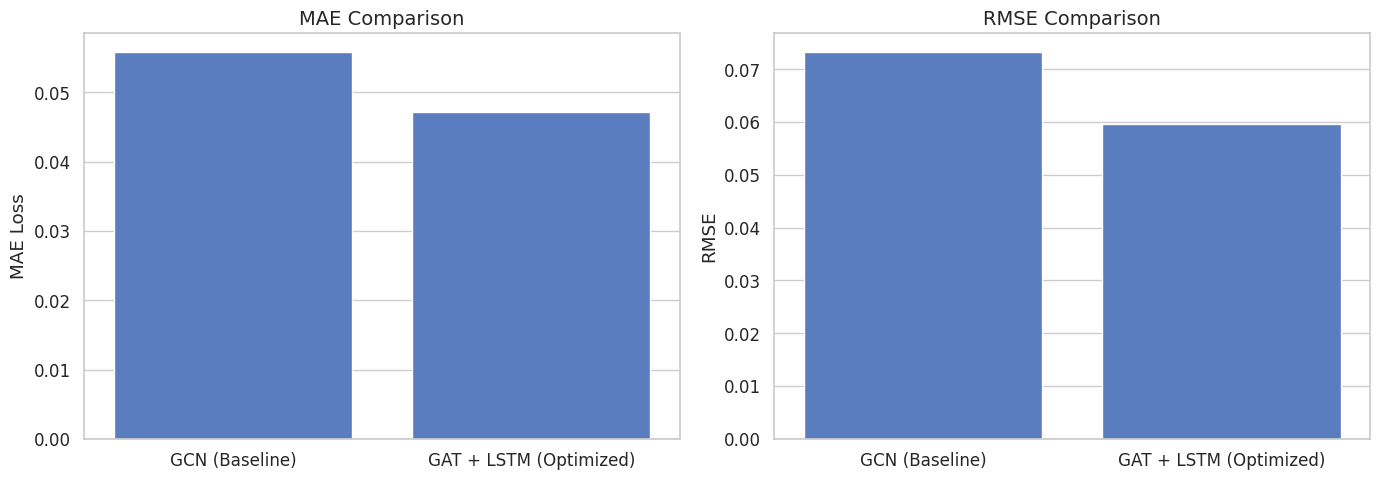

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
metrics_df = pd.DataFrame({
    'Model': ['GCN (Baseline)', 'GAT + LSTM (Optimized)'],
    'MAE': [0.0558, round(mae, 4)],
    'RMSE': [0.0732, round(rmse, 4)],
    'R2': [0.7681, round(r2, 4)]
})

# Set style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Plot MAE and RMSE side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='Model', y='MAE', data=metrics_df, ax=axes[0])
axes[0].set_title('MAE Comparison', fontsize=14)
axes[0].set_ylabel('MAE Loss')
axes[0].set_xlabel('')

sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=axes[1])
axes[1].set_title('RMSE Comparison', fontsize=14)
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()


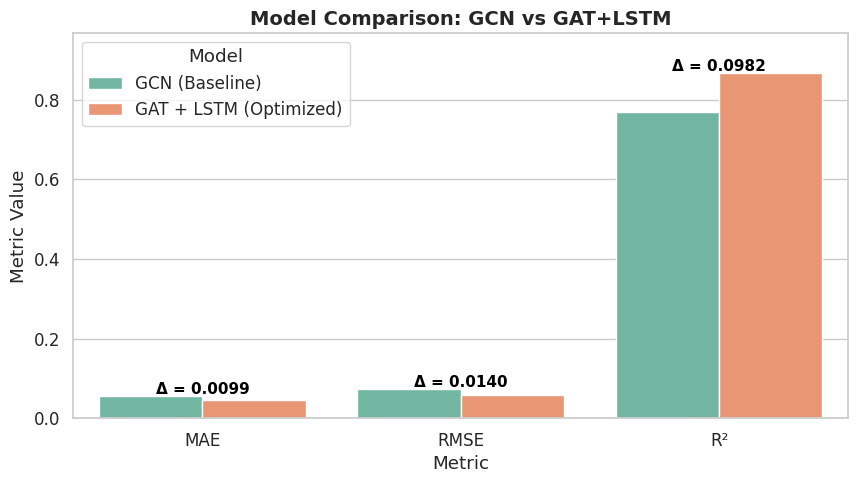

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comparison Data
comparison_df = pd.DataFrame({
    "Model": ["GCN (Baseline)", "GAT + LSTM (Optimized)"],
    "MAE": [0.0558, 0.0459],
    "RMSE": [0.0732, 0.0592],
    "R²": [0.7681, 0.8663]
})

# Compute improvement deltas
deltas = {
    'MAE': comparison_df['MAE'].iloc[0] - comparison_df['MAE'].iloc[1],
    'RMSE': comparison_df['RMSE'].iloc[0] - comparison_df['RMSE'].iloc[1],
    'R²': comparison_df['R²'].iloc[1] - comparison_df['R²'].iloc[0]
}

# Melt for seaborn
melt_df = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=melt_df, x="Metric", y="Value", hue="Model", palette="Set2")

# Annotate delta
for i, metric in enumerate(['MAE','RMSE','R²']):
    plt.text(i, max(comparison_df[metric])+0.005, f"Δ = {deltas[metric]:.4f}",
             ha='center', fontsize=11, fontweight='bold', color='black')

plt.title("Model Comparison: GCN vs GAT+LSTM", fontsize=14, fontweight='bold')
plt.ylabel("Metric Value")
plt.ylim(0, max(comparison_df[['MAE','RMSE','R²']].max()) + 0.1)
plt.show()


In [11]:
!pip install ipywidgets plotly
from google.colab import output
output.enable_custom_widget_manager()


In [12]:
sales_df.columns


Index(['src', 'dst', 'quantity', 'timestamp', 'is_weekend'], dtype='object')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Ensure timestamp is datetime
# -----------------------------
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'])

# -----------------------------
# Inventory estimation
# -----------------------------
def estimate_inventory(product_id):
    df = sales_df[sales_df['dst'] == product_id].sort_values('timestamp')
    if df.empty:
        return 0
    return round(df.tail(3)['quantity'].mean(), 2)

# -----------------------------
# Forecast function
# -----------------------------
def forecast_demand(product_id, days_ahead=7):
    df = sales_df[sales_df['dst'] == product_id].sort_values('timestamp')
    if df.empty:
        return None, pd.DataFrame(columns=['Date', 'Forecasted_Quantity'])

    hist = df[['timestamp', 'quantity']].copy()
    last_qty = hist['quantity'].iloc[-1]
    trend = (hist['quantity'].iloc[-1] - hist['quantity'].iloc[-4]) / 4 if len(hist) > 4 else 0

    future_dates = pd.date_range(hist['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=days_ahead)
    forecast_values = [max(0, last_qty + i * trend) for i in range(days_ahead)]

    forecast_df = pd.DataFrame({
        'Date': future_dates.strftime('%Y-%m-%d'),
        'Forecasted_Quantity': np.round(forecast_values, 2)
    })
    return hist, forecast_df

# -----------------------------
# Placement suggestion helper
# -----------------------------
def placement_suggestion(priority):
    if priority == 'High':
        return "🏷️ Front/Dispatch zone — high movement"
    elif priority == 'Medium':
        return "📦 Middle racks — moderate turnover"
    else:
        return "📥 Back storage — low demand"

# -----------------------------
# Plot + table + summary + placement
# -----------------------------
def plot_forecast_static(product_id, days_ahead):
    hist, forecast_df = forecast_demand(product_id, days_ahead)
    inventory_level = estimate_inventory(product_id)

    if hist is None or forecast_df.empty:
        print("⚠️ Not enough data to forecast this product.")
        return

    # Automatic interval selection
    interval_days = 1 if days_ahead <= 7 else 3 if days_ahead <= 21 else 7

    # Interval sums
    interval_forecast = [
        forecast_df['Forecasted_Quantity'].iloc[i:i+interval_days].sum()
        for i in range(0, len(forecast_df), interval_days)
    ]
    interval_dates = [
        forecast_df['Date'].iloc[min(i+interval_days-1, len(forecast_df)-1)]
        for i in range(0, len(forecast_df), interval_days)
    ]
    cumulative_forecast = np.cumsum(interval_forecast)

    # Restock threshold (70%)
    restock_threshold = 0.7 * inventory_level
    restock_day = next((d for d, cum in zip(interval_dates, cumulative_forecast) if cum >= restock_threshold), None)

    # Plot
    colors = ['red' if q > inventory_level else 'green' for q in interval_forecast]
    plt.figure(figsize=(10,5))
    plt.plot(hist['timestamp'], hist['quantity'], marker='o', label='Historical', color='steelblue')
    plt.scatter(pd.to_datetime(interval_dates), interval_forecast, color=colors, s=100, label=f'Forecast ({interval_days}-day interval)')
    plt.axhline(inventory_level, color='red', linestyle='--', label=f'Inventory ({inventory_level})')
    plt.title(f'Demand Forecast for {product_id} ({interval_days}-day intervals)')
    plt.xlabel('Date'); plt.ylabel('Quantity')
    plt.xticks(rotation=45); plt.grid(True, alpha=0.3)
    plt.legend(); plt.tight_layout(); plt.show()

    # Interval table
    interval_table = pd.DataFrame({
        'Interval End Date': interval_dates,
        f'Forecasted Quantity ({interval_days}-day)': np.round(interval_forecast, 2),
        'Cumulative Forecast': np.round(cumulative_forecast, 2)
    })
    print("📊 Interval Forecast Values:")
    display(interval_table)

    # Summary
    avg_interval_forecast = np.mean(interval_forecast)
    consumption_percent = (avg_interval_forecast / inventory_level * 100) if inventory_level > 0 else 0
    if consumption_percent < 50:
        status, priority = "🟢 Inventory healthy — no restock needed.", "Low"
    elif 50 <= consumption_percent < 70:
        status, priority = "🟡 Inventory moderate — monitor demand closely.", "Medium"
    elif 70 <= consumption_percent < 90:
        status, priority = "🟠 Inventory low — plan restock soon.", "High"
    else:
        status, priority = "🔴 Critical! Forecasted demand exceeds inventory.", "High"

    print("\n📈 Inventory vs Demand Summary:")
    print(f"   → Avg Forecast per Interval: {avg_interval_forecast:.2f} units")
    print(f"   → Current Inventory: {inventory_level:.2f} units")
    print(f"   → Consumption Rate: {consumption_percent:.2f}% of inventory")
    print(status)

    if restock_day:
        print(f"⚠️ Restock likely needed by {restock_day} (70% inventory usage)")
    else:
        print("✅ Inventory sufficient for the forecast period.")

    # -----------------------------
    # 📦 Placement Table
    # -----------------------------
    placement_table = pd.DataFrame({
        'Product': [product_id],
        'Avg_Demand': [round(np.mean(forecast_df['Forecasted_Quantity']), 2)],
        'Priority_Level': [priority],
        'Suggested_Placement': [placement_suggestion(priority)]
    })

    print("\n📦 Placement Recommendations:")
    display(placement_table)

# -----------------------------
# Widgets
# -----------------------------
product_search = widgets.Combobox(
    placeholder='Type or select a product...',
    options=sorted(sales_df['dst'].astype(str).unique()),
    description='Product:',
    ensure_option=True,
    layout=widgets.Layout(width='400px')
)

days_slider = widgets.IntSlider(
    value=7, min=3, max=30, step=1,
    description='Days to Forecast:',
    layout=widgets.Layout(width='400px')
)

run_button = widgets.Button(
    description='Run Forecast',
    button_style='success',
    layout=widgets.Layout(width='200px')
)

output_box = widgets.Output()

def on_run_clicked(b):
    with output_box:
        clear_output(wait=True)
        product_id = product_search.value
        if not product_id or product_id not in sales_df['dst'].astype(str).unique():
            print("⚠️ Please type or select a valid product.")
            return
        plot_forecast_static(product_id, days_slider.value)

run_button.on_click(on_run_clicked)

display(widgets.VBox([
    widgets.HBox([product_search, days_slider, run_button]),
    output_box
]))


In [16]:
# Check columns for each dataset
print("📦 Nodes and Edges (Plant & Storage) Columns:")
print(nodes_and_target_df.columns.tolist(), "\n")

print("📦 Dynamic Supply Chain Features Columns:")
print(features_df.columns.tolist(), "\n")

print("📦 Sales Order Columns:")
print(sales_df.columns.tolist(), "\n")


print("📦 Nodes Columns:")
print(nodes_df.columns.tolist())


📦 Nodes and Edges (Plant & Storage) Columns:
['node_id', 'node_type', 'supplier_feature_reliability'] 

📦 Dynamic Supply Chain Features Columns:
['warehouse_inventory_level', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'disruption_likelihood_score', 'delay_probability', 'risk_classification', 'delivery_time_deviation', 'product_id', 'node_id', 'supplier_country'] 

📦 Sales Order Columns:
['src', 'dst', 'quantity', 'timestamp', 'is_weekend'] 

📦 Nodes Columns:
['node_id', 'node_type', 'supplier_feature_reliability', 'warehouse_inventory_level', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'cargo_condition_status', 'route_risk_level', 'customs_clearan

In [17]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Load dataset
# -----------------------------
features_df = pd.read_csv("dynamic_supply_chain_logistics_dataset_updated.csv")

# Clean column names
features_df.columns = features_df.columns.str.strip().str.replace('\ufeff','')

# -----------------------------
# Prepare supplier dataframe
# -----------------------------
supplier_df = features_df[['supplier_id', 'supplier_reliability_score', 'lead_time_days', 'disruption_likelihood_score']].drop_duplicates()

# -----------------------------
# Supplier assessment function
# -----------------------------
def supplier_assessment(reliability, lead_time, disruption_score=None):
    if reliability >= 0.8 and lead_time <= 3 and (disruption_score is None or disruption_score < 0.3):
        return "Excellent"
    elif reliability >= 0.6 and lead_time <= 5:
        return "Good"
    elif reliability >= 0.4:
        return "Average"
    else:
        return "Poor"

supplier_df['Assessment'] = supplier_df.apply(
    lambda x: supplier_assessment(
        x['supplier_reliability_score'],
        x['lead_time_days'],
        x['disruption_likelihood_score']
    ), axis=1
)

# -----------------------------
# Full summary metrics (all suppliers)
# -----------------------------
full_metrics = supplier_df.groupby('Assessment').agg(
    Avg_Reliability=('supplier_reliability_score','mean'),
    Avg_LeadTime=('lead_time_days','mean'),
    Avg_Disruption=('disruption_likelihood_score','mean'),
    Count=('supplier_id','count')
).reset_index()

print("Full Summary Metrics by Assessment (All Suppliers):")
display(full_metrics)

# -----------------------------
# Inclusive slider defaults
# -----------------------------
min_reliability = widgets.FloatSlider(
    value=0.4,    # Lower bound to include Poor suppliers
    min=0.4,
    max=1.0,
    step=0.01,
    description='Min Reliability:'
)

max_leadtime = widgets.FloatSlider(
    value=10.0,   # Upper bound to include slow suppliers
    min=1.0,
    max=10.0,
    step=0.1,
    description='Max Lead Time:'
)

assessment_filter = widgets.Dropdown(
    options=['All', 'Excellent', 'Good', 'Average', 'Poor'],
    description='Assessment:'
)

output = widgets.Output()

# -----------------------------
# Dashboard update function
# -----------------------------
def update_dashboard(change):
    with output:
        clear_output()
        # Filter suppliers
        df = supplier_df[
            (supplier_df['supplier_reliability_score'] >= min_reliability.value) &
            (supplier_df['lead_time_days'] <= max_leadtime.value)
        ]
        if assessment_filter.value != 'All':
            df = df[df['Assessment'] == assessment_filter.value]

        # Display filtered supplier table
        print("Filtered Supplier Table:")
        display(df.reset_index(drop=True))

        # Summary metrics for filtered suppliers
        metrics = df.groupby('Assessment').agg(
            Avg_Reliability=('supplier_reliability_score','mean'),
            Avg_LeadTime=('lead_time_days','mean'),
            Avg_Disruption=('disruption_likelihood_score','mean'),
            Count=('supplier_id','count')
        ).reset_index()

        print("\nSummary Metrics by Assessment (Filtered):")
        display(metrics)

# Link widgets
min_reliability.observe(update_dashboard, 'value')
max_leadtime.observe(update_dashboard, 'value')
assessment_filter.observe(update_dashboard, 'value')

# Display interactive dashboard
display(widgets.VBox([min_reliability, max_leadtime, assessment_filter, output]))
update_dashboard(None)


Full Summary Metrics by Assessment (All Suppliers):


,Assessment,Avg_Reliability,Avg_LeadTime,Avg_Disruption,Count
0,Average,0.718719,7.827843,0.790542,443
1,Excellent,0.981847,1.791849,0.113476,26
2,Good,0.857128,2.212970,0.857683,440
3,Poor,0.154294,5.684673,0.799951,700


In [18]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
features_df = pd.read_csv("dynamic_supply_chain_logistics_dataset_updated.csv")

# Clean column names
features_df.columns = features_df.columns.str.strip().str.replace('\ufeff','')

# -----------------------------
# Prepare supplier dataframe
# -----------------------------
supplier_df = features_df[['supplier_id', 'supplier_reliability_score', 'lead_time_days', 'disruption_likelihood_score']].drop_duplicates()

# -----------------------------
# Supplier assessment function
# -----------------------------
def supplier_assessment(reliability, lead_time, disruption_score=None):
    if reliability >= 0.8 and lead_time <= 3 and (disruption_score is None or disruption_score < 0.3):
        return "Excellent"
    elif reliability >= 0.6 and lead_time <= 5:
        return "Good"
    elif reliability >= 0.4:
        return "Average"
    else:
        return "Poor"

supplier_df['Assessment'] = supplier_df.apply(
    lambda x: supplier_assessment(
        x['supplier_reliability_score'],
        x['lead_time_days'],
        x['disruption_likelihood_score']
    ), axis=1
)

# -----------------------------
# Full summary metrics (all suppliers)
# -----------------------------
full_metrics = supplier_df.groupby('Assessment').agg(
    Avg_Reliability=('supplier_reliability_score','mean'),
    Avg_LeadTime=('lead_time_days','mean'),
    Avg_Disruption=('disruption_likelihood_score','mean'),
    Count=('supplier_id','count')
).reset_index()

print("Full Summary Metrics by Assessment (All Suppliers):")
display(full_metrics)

# -----------------------------
# Inclusive slider defaults
# -----------------------------
min_reliability = widgets.FloatSlider(
    value=0.4,    # Lower bound to include Poor suppliers
    min=0.4,
    max=1.0,
    step=0.01,
    description='Min Reliability:'
)

max_leadtime = widgets.FloatSlider(
    value=10.0,   # Upper bound to include slow suppliers
    min=1.0,
    max=10.0,
    step=0.1,
    description='Max Lead Time:'
)

assessment_filter = widgets.Dropdown(
    options=['All', 'Excellent', 'Good', 'Average', 'Poor'],
    description='Assessment:'
)

output = widgets.Output()

# -----------------------------
# Dashboard update function
# -----------------------------
def update_dashboard(change):
    with output:
        clear_output()
        # Filter suppliers
        df = supplier_df[
            (supplier_df['supplier_reliability_score'] >= min_reliability.value) &
            (supplier_df['lead_time_days'] <= max_leadtime.value)
        ]
        if assessment_filter.value != 'All':
            df = df[df['Assessment'] == assessment_filter.value]

        # Display filtered supplier table
        print("Filtered Supplier Table:")
        display(df.reset_index(drop=True))

        # Summary metrics for filtered suppliers
        metrics = df.groupby('Assessment').agg(
            Avg_Reliability=('supplier_reliability_score','mean'),
            Avg_LeadTime=('lead_time_days','mean'),
            Avg_Disruption=('disruption_likelihood_score','mean'),
            Count=('supplier_id','count')
        ).reset_index()

        print("\nSummary Metrics by Assessment (Filtered):")
        display(metrics)

        # -----------------------------
        # Bar chart for filtered suppliers only
        # -----------------------------
        if not metrics.empty:
            plt.figure(figsize=(6,4))
            plt.bar(metrics['Assessment'], metrics['Count'], color=['green','yellow','orange','red'])
            plt.title('Supplier Count by Assessment (Filtered)')
            plt.ylabel('Number of Suppliers')
            plt.xlabel('Assessment')
            plt.show()

# Link widgets
min_reliability.observe(update_dashboard, 'value')
max_leadtime.observe(update_dashboard, 'value')
assessment_filter.observe(update_dashboard, 'value')

# Display interactive dashboard
display(widgets.VBox([min_reliability, max_leadtime, assessment_filter, output]))
update_dashboard(None)


Full Summary Metrics by Assessment (All Suppliers):


,Assessment,Avg_Reliability,Avg_LeadTime,Avg_Disruption,Count
0,Average,0.718719,7.827843,0.790542,443
1,Excellent,0.981847,1.791849,0.113476,26
2,Good,0.857128,2.212970,0.857683,440
3,Poor,0.154294,5.684673,0.799951,700
